<h2>Bagging and AdaBoost</h2>


<p> In this project, you are going to implement bagging and AdaBoost for Regression Trees. To start, we will import some packages we need: </p>

In [1]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import helper as h
%matplotlib notebook

In addition, we'll create a 2D spiral dataset of size 150 for visualization and a high dimensional dataset <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral= h.spiraldata(150)
xTrIon,yTrIon,xTeIon,yTeIon= h.iondata()

We are going to use the regression tree that we used in our previous project. As a reminder, the following code shows you how to instantiate a decision tree:

In [3]:
# Create a regression tree with no restriction on its depth
# and weights for each training example to be 1
# if you want to create a tree of max_depth k
# then call h.RegressionTree(depth=k)
tree = h.RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTrSpiral, yTrSpiral)

# To use the trained regression tree to make prediction
pred = tree.predict(xTrSpiral)

tr_err   = np.mean((np.sign(tree.predict(xTrSpiral)) - yTrSpiral)**2)
te_err   = np.mean((np.sign(tree.predict(xTeSpiral)) - yTeSpiral)**2)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

Training error: 0.0000
Testing error:  0.0533


In addition, we have also implemented a decision tree that weigh different training examples differently during training for you. Consider you have training examples $(\mathbf{x}_i, y_i)$ and you want to weigh each example with a positive weight $w_i$ during training. Then essentially what you want to do is to create a decision tree that minimizes:

$$ \sum_{i=1}^n\frac{w_i}{Z}  (tree(\mathbf{x}_i) - y_i)^2 \textrm{ where: } Z=\sum_{j = 1}^n w_j$$

The following cell is an example to create such tree:

In [14]:
# Generate random weights
# weights[i] is the weight for i-th training example
weights = np.random.rand(len(xTrSpiral))

# Train a regression tree with the prespecified weights
# the default for weights is None which weigh all training examples equally
tree = h.RegressionTree(depth=np.inf, weights=weights)

# To fit/train the regression tree
tree.fit(xTrSpiral, yTrSpiral)

# To use the trained regression tree to make prediction
pred = tree.predict(xTrSpiral)

tr_err   = np.mean((np.sign(tree.predict(xTrSpiral)) - yTrSpiral)**2)
te_err   = np.mean((np.sign(tree.predict(xTeSpiral)) - yTeSpiral)**2)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

Training error: 0.0000
Testing error:  0.0533


Note that if we set the weights to be one for all training examples (i.e. $w_i = 1$ for every training examples), we recover the decision tree we implemented in the previous project. This extra weighting feature is useful you implement AdaBoost. 

<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the spiral data set. </p>

<IPython.core.display.Javascript object>


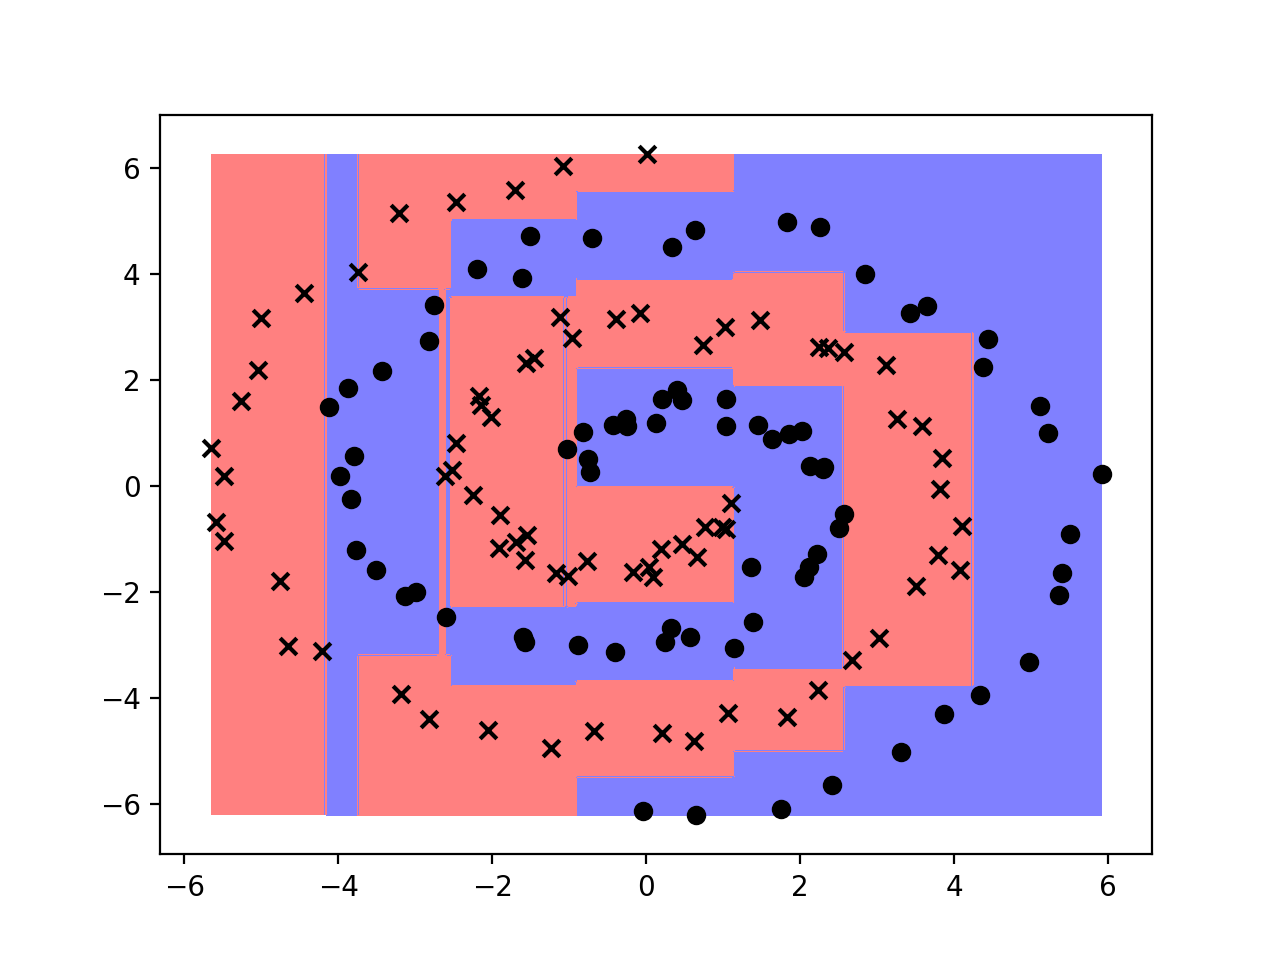

Training error: 0.0000
Testing error:  0.0533


In [15]:
def visclassifier(fun,xTr,yTr):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    
    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
                   )

    plt.axis('tight')
    # shows figure and blocks
    plt.show()
    

tree=h.RegressionTree(depth=np.inf)
tree.fit(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X: tree.predict(X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

<h2>Bagging</h2>
<p>CART trees are known to be high variance classifiers
(if trained to full depth).
An effective way to prevent overfitting is to use <b>Bagging</b> (short for bootstrap aggregating).
Implement the function <code>forest</code>,
which builds a forest of regression trees.
Each tree should be built using training data
drawn by randomly sampling $n$ examples
from the training data with replacement.
Do not randomly sample features.
The function should output a list of trees.</p>

In [16]:
def forest(xTr, yTr, m, maxdepth=np.inf):
    """Creates a random forest.
    
    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        
    Output:
        trees: list of decision trees of length m
    """
    
    n, d = xTr.shape
    trees = []
    
    ### BEGIN SOLUTION
    for i in range(m):
        indices = np.random.choice(n, n)
        tree = h.RegressionTree(depth=maxdepth)
        tree.fit(xTr[indices, :], yTr[indices])
        trees.append(tree)
    ### END SOLUTION
    
    return trees

In [17]:
def forest_test1():
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m)
    return len(trees) == m # make sure there are m trees in the forest

def forest_test2():
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    max_depth = 4
    trees = forest(x, y, m, max_depth)
    depths_forest = np.array([tree.depth for tree in trees]) # Get the depth of all trees in the forest
    return np.all(depths_forest == max_depth) # make sure that the max depth of all the trees is correct


def forest_test3():
    s = set()

    def DFScollect(tree):
        # Do Depth first search to all prediction in the tree
        if tree.left is None and tree.right is None:
            s.add(tree.prediction)
        else:
            DFScollect(tree.right)
            DFScollect(tree.left)

    m = 200
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m);

    lens = np.zeros(m)

    for i in range(m):
        s.clear()
        DFScollect(trees[i].root)
        lens[i] = len(s)

    # Check that about 63% of data is represented in each random sample
    return abs(np.mean(lens) - 100 * (1 - 1 / np.exp(1))) < 2

h.runtest(forest_test1, 'forest_test1')
h.runtest(forest_test2, 'forest_test2')
h.runtest(forest_test3, 'forest_test3')

Running Test: forest_test1 ... ✔ Passed!
Running Test: forest_test2 ... ✔ Passed!
Running Test: forest_test3 ... ✔ Passed!


In [18]:
# Autograder test cell - worth 1 point
# runs forest_test1
### BEGIN HIDDEN TESTS

m = 20
x = np.arange(100).reshape((100, 1))
y = np.arange(100)
trees = forest(x, y, m)
assert len(trees) == m # make sure there are n trees in the forest

### END HIDDEN TESTS

In [9]:
# Autograder test cell - worth 1 point
# runs forest_test2
### BEGIN HIDDEN TESTS

m = 20
x = np.arange(100).reshape((100, 1))
y = np.arange(100)
max_depth = 4
trees = forest(x, y, m, max_depth)
depths_forest = np.array([tree.depth for tree in trees]) # Get the depth of all trees in the forest
assert np.all(depths_forest == max_depth)

### END HIDDEN TESTS

In [10]:
# Autograder test cell - worth 1 point
# runs forest_test3
### BEGIN HIDDEN TESTS
s = set()

def DFScollect(tree):
    # Do Depth first search to all prediction in the tree
    if tree.left is None and tree.right is None:
        s.add(tree.prediction)
    else:
        DFScollect(tree.right)
        DFScollect(tree.left)

m = 200
x = np.arange(100).reshape((100, 1))
y = np.arange(100)
trees = forest(x, y, m)

lens = np.zeros(m)

for i in range(m):
    s.clear()
    DFScollect(trees[i].root)
    lens[i] = len(s)

# Check that about 63% of data is represented in each random sample
assert abs(np.mean(lens) - 100 * (1 - 1 / np.exp(1))) < 2

### END HIDDEN TESTS

<p>Now implement the function <code>evalforest</code>, which should take as input a set of $m$ trees, a set of $n$ test inputs, and an $m$ dimensional weight vector. Each tree should be weighted by the corresponding weight. (For bagged decision trees you can define the weights to be $\frac{1}{m}$ for all trees).</p>

In [11]:
def evalforest(trees, X, alphas=None):
    """Evaluates X using trees.
    
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
        
    Output:
        pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    
    if alphas is None:
        alphas = np.ones(m) / len(trees)
            
    pred = np.zeros(n)
    
    # BEGIN SOLUTION
    for t in range(m):
        pred += alphas[t] * np.sign(trees[t].predict(X))      
    # END SOLUTION
    return pred

In [12]:
def evalforest_test1():
    m = 200
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m)
    
    preds = evalforest(trees, x)
    return preds.shape == y.shape

def evalforest_test2():
    m = 200
    x = np.ones(10).reshape((10, 1))
    y = np.ones(10)
    max_depth = 0
    
    # Create a forest with trees depth 0
    # Since the data are all ones, each tree will return 1 as prediction
    trees = forest(x, y, m, 0) 
    
    # assign the k-th tree in the forest with weight k
    alphas = np.arange(1, m + 1)
    pred = evalforest(trees, np.ones((1, 1)), alphas)[0]
    return pred == np.sum(alphas) # the prediction should be equal to the sum of weights
    
def bagging_test1():
    m = 50
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

    tree = h.RegressionTree(depth=5)
    tree.fit(xTr, yTr)
    oneacc = np.sum(np.sign(tree.predict(xTe)) == yTe)

    trees = forest(xTr, yTr, m, maxdepth=5)
    multiacc = np.sum(np.sign(evalforest(trees, xTe)) == yTe)

    # Check that bagging yields improvement - or doesn't get too much worse
    return multiacc * 1.1 >= oneacc

def bagging_test2():
    m = 50
    xTr = (np.random.rand(500,3) - 0.5) * 4
    yTr = xTr[:,0] * xTr[:,1] * xTr[:,2] # XOR Regression
    xTe = (np.random.rand(50,3) - 0.5) * 4
    yTe = xTe[:,0] * xTe[:,1] * xTe[:,2]
    
    np.random.seed(1)
    tree = h.RegressionTree(depth=3)
    tree.fit(xTr, yTr)
    oneerr = np.sum(np.sqrt((tree.predict(xTe) - yTe) ** 2))

    trees = forest(xTr, yTr, m, maxdepth=3)
    multierr = np.sum(np.sqrt((evalforest(trees, xTe) - yTe) ** 2))

    # Check that bagging yields improvement - or doesn't get too much worse
    return multierr <= oneerr * 1.5

h.runtest(evalforest_test1, 'evalforest_test1')
h.runtest(evalforest_test2, 'evalforest_test2')
h.runtest(bagging_test1, 'bagging_test1')
h.runtest(bagging_test2, 'bagging_test2')

Running Test: evalforest_test1 ... ✔ Passed!
Running Test: evalforest_test2 ... ✔ Passed!
Running Test: bagging_test1 ... ✔ Passed!
Running Test: bagging_test2 ... ✔ Passed!


In [13]:
# Autograder test cell - worth 1 point
# runs evalforest-test1
### BEGIN HIDDEN TESTS
m = 200
x = np.arange(100).reshape((100, 1))
y = np.arange(100)
trees = forest(x, y, m)

preds = evalforest(trees, x)
assert preds.shape == y.shape
### END HIDDEN TESTS

In [14]:
# Autograder test cell - worth 1 point
# runs evalforest-test2
### BEGIN HIDDEN TESTS
m = 200
x = np.ones(10).reshape((10, 1))
y = np.ones(10)
max_depth = 0

# Create a forest with trees depth 0
# Since the data are all ones, each tree will return 1 as prediction
trees = forest(x, y, m, 0) 

# assign the k-th tree in the forest with weight k
alphas = np.arange(1, m + 1)
pred = evalforest(trees, np.ones((1, 1)), alphas)[0]
assert pred == np.sum(alphas) # the prediction should be equal to the sum of weights
### END HIDDEN TESTS

In [9]:
# Autograder test cell - worth 1 point
# runs bagging-test1
### BEGIN HIDDEN TESTS
n = 50
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

tree = h.RegressionTree(depth=5)
tree.fit(xTr, yTr)
oneacc = np.sum(np.sign(tree.predict(xTe)) == yTe)

trees = forest(xTr, yTr, n, maxdepth=5)
multiacc = np.sum(np.sign(evalforest(trees, xTe)) == yTe)

# Check that bagging yields improvement - or doesn't get too much worse
assert multiacc * 1.1 >= oneacc
### END HIDDEN TESTS

NameError: name 'evalforest' is not defined

In [ ]:
# Autograder test cell - worth 1 point
# runs bagging-test2
### BEGIN HIDDEN TESTS
n = 50
xTr = (np.random.rand(500,3) - 0.5) * 4
yTr = xTr[:,0] * xTr[:,1] * xTr[:,2] # XOR Regression
xTe = (np.random.rand(50,3) - 0.5) * 4
yTe = xTe[:,0] * xTe[:,1] * xTe[:,2]

np.random.seed(1)
tree = h.RegressionTree(depth=3)
tree.fit(xTr, yTr)
oneerr = np.sum(np.sqrt((tree.predict(xTe) - yTe) ** 2))

trees = forest(xTr, yTr, n, maxdepth=3)
multierr = np.sum(np.sqrt((evalforest(trees, xTe) - yTe) ** 2))

# Check that bagging yields improvement - or doesn't get too much worse
assert multierr <= oneerr * 1.5
### END HIDDEN TESTS

<p>The following script visualizes the decision boundary of an ensemble of decision tree.</p>

In [ ]:
trees=forest(xTrSpiral,yTrSpiral, 50) # compute tree on training data 
visclassifier(lambda X:evalforest(trees,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

<p>The following script evaluates the test and training error of an ensemble of decision trees as we vary the number of trees.</p>

In [ ]:
M=20 # max number of trees
err_trB=[]
err_teB=[]
alltrees=forest(xTrIon,yTrIon,M)
for i in range(M):
    trees=alltrees[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon)) != yTrIon)
    teErr = np.mean(np.sign(evalforest(trees,xTeIon)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

<IPython.core.display.Javascript object>


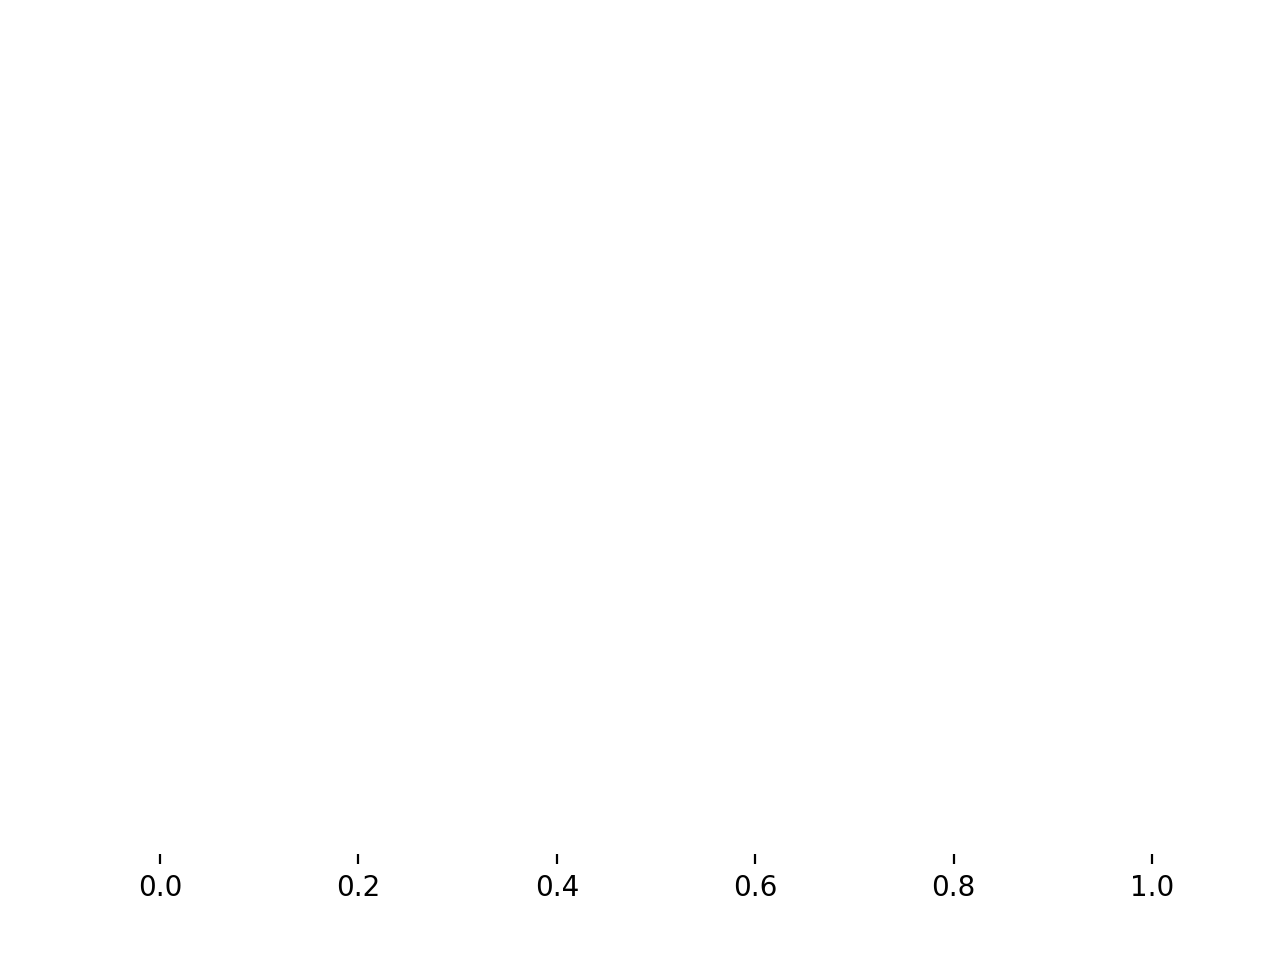

Note: there is strong delay between points


Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [10]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
        
    w = np.array(w).flatten()
    
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest
    trees=forest(xTrain,yTrain,M)
    fun = lambda X:evalforest(trees,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTrain= np.array([[5,6]])
b=yTrIon
yTrain = np.array([1])
w=xTrIon
M=20

%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Note: there is strong delay between points')
plt.title('Use shift-click to add negative points.')

<h2>Boosting</h2>

<p>Another option to improve your decision trees is to build trees of small depth (e.g. only depth=3 or depth=4). These do not have high variance, but instead suffer from <b>high bias</b>. You can reduce the bias of a classifier with boosting. Implement the function <code>boosttree</code>, which applies Adaboost to the decision tree model. You should be able to use the function <code>evalforest</code> to evaluate your boosted ensemble (provdided you pass on the weights correctly.)</p>

In [20]:
def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []

    ### BEGIN SOLUTION 
    for i in range(maxiter):
        tree = h.RegressionTree(depth=maxdepth, weights=weights)
        tree.fit(x, y)
        preds = np.sign(tree.predict(x))
        results = (preds != y)
        err = np.sum(results * weights)
        if err > 0.5 - np.finfo(float).eps:
            print("error is too large?", err, "max error", 0.5 - np.finfo(float).eps or abs(err) < np.finfo(float).eps)
            break
        elif abs(err) < np.finfo(float).eps:
            # classification is so simple that one tree is enough
            return [tree], [1]
        
        alpha = 0.5 * np.log((1-err)/err)
        forest.append(tree)
        alphas.append(alpha)
        weights = weights*np.exp(alpha * (results*2 - 1))
        weights = weights/sum(weights)
    ### END SOLUTION
    
    return forest, alphas

In [21]:
def boosting_test1():
    maxiter = 50
    maxdepth = 4
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])
    
    out = boosttree(xTr, yTr, maxiter, maxdepth)
    return len(out) == 2 #  boosttrees function should return a tuple

def boosting_test2():
    maxiter = 50
    maxdepth = 4
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])
    
    trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
    return len(trees) == len(alphas) #  the len of the two returned output should be the same

def boosting_test3():
    maxiter = 50
    maxdepth = 3
    xTr = np.random.rand(500,3) - 0.5
    yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
    xTe = np.random.rand(50,3) - 0.5
    yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

    tree = h.RegressionTree(maxdepth)
    tree.fit(xTr, yTr)
    oneacc = np.sum(np.sign(tree.predict(xTe)) == yTe)

    trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
    multiacc = np.sum(np.sign(evalforest(trees, xTe, alphas)) == yTe)
    return multiacc >= oneacc

h.runtest(boosting_test1, 'boosting_test1')
h.runtest(boosting_test2, 'boosting_test2')
h.runtest(boosting_test3, 'boosting_test3')

Running Test: boosting_test1 ... ✔ Passed!
Running Test: boosting_test2 ... ✔ Passed!
Running Test: boosting_test3 ... ✔ Passed!


In [22]:
# Autograder test cell - worth 1 point
# runs boosting_test1
### BEGIN HIDDEN TESTS
maxiter = 50
maxdepth = 4
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

out = boosttree(xTr, yTr, maxiter, maxdepth)
assert len(out) == 2 #  boosttrees function should return a tuple
### END HIDDEN TESTS

In [23]:
# Autograder test cell - worth 1 point
# runs boosting_test2
### BEGIN HIDDEN TESTS
maxiter = 50
maxdepth = 4
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
assert len(trees) == len(alphas) #  the len of the two returned output should be the same
### END HIDDEN TESTS

In [24]:
# Autograder test cell - worth 1 point
# runs boosting_test3
### BEGIN HIDDEN TESTS
maxiter = 50
maxdepth = 3
xTr = np.random.rand(500,3) - 0.5
yTr = np.sign(xTr[:,0] * xTr[:,1] * xTr[:,2]) # XOR Classification
xTe = np.random.rand(50,3) - 0.5
yTe = np.sign(xTe[:,0] * xTe[:,1] * xTe[:,2])

tree = h.RegressionTree(maxdepth)
tree.fit(xTr, yTr)
oneacc = np.sum(np.sign(tree.predict(xTe)) == yTe)

trees, alphas = boosttree(xTr, yTr, maxiter, maxdepth)
multiacc = np.sum(np.sign(evalforest(trees, xTe, alphas)) == yTe)
assert multiacc >= oneacc
### END HIDDEN TESTS

<p>The following script evaluates the test and training error of a boosted forest as we increase the number of trees.</p>

[0] exp loss = 0.5022 training err = 0.0676	testing err = 0.1429
[1] exp loss = 0.2779 training err = 0.0676	testing err = 0.1429
[2] exp loss = 0.1300 training err = 0.0107	testing err = 0.1857
[3] exp loss = 0.0712 training err = 0.0214	testing err = 0.2429
[4] exp loss = 0.0417 training err = 0.0000	testing err = 0.1429
[5] exp loss = 0.0172 training err = 0.0000	testing err = 0.0857
[6] exp loss = 0.0131 training err = 0.0000	testing err = 0.1143
[7] exp loss = 0.0085 training err = 0.0000	testing err = 0.1000
[8] exp loss = 0.0041 training err = 0.0000	testing err = 0.1143
[9] exp loss = 0.0022 training err = 0.0000	testing err = 0.1143
[10] exp loss = 0.0013 training err = 0.0000	testing err = 0.1000
[11] exp loss = 0.0006 training err = 0.0000	testing err = 0.0714
[12] exp loss = 0.0003 training err = 0.0000	testing err = 0.0714
[13] exp loss = 0.0002 training err = 0.0000	testing err = 0.0571
[14] exp loss = 0.0001 training err = 0.0000	testing err = 0.1143
[15] exp loss = 0.00

<IPython.core.display.Javascript object>


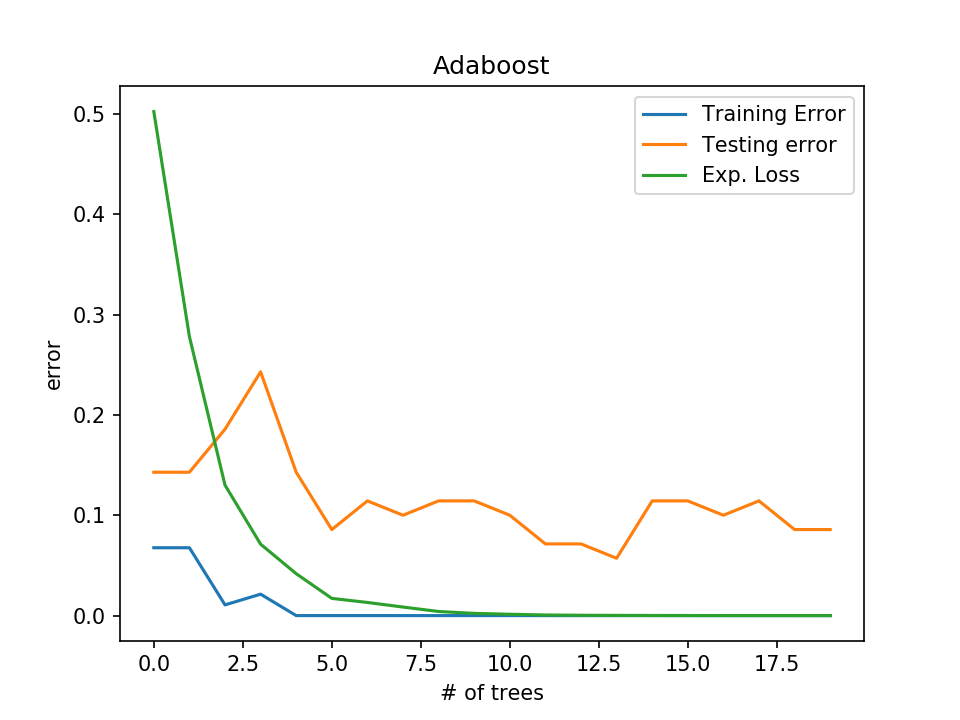

In [25]:
M=20 # max number of trees
alltrees,allalphas=boosttree(xTrIon,yTrIon,maxdepth=3,maxiter=M)

err_trB=[]
loss_trB=[]
err_teB=[]
for i in range(M):
    trees=alltrees[:i+1]
    alphas=allalphas[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon,alphas)) != yTrIon)
    trLoss =np.mean(np.exp(-evalforest(trees,xTrIon,alphas)*yTrIon))
    teErr = np.mean(np.sign(evalforest(trees,xTeIon,alphas)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    loss_trB.append(trLoss)
    print("[%d] exp loss = %.4f training err = %.4f\ttesting err = %.4f" % (i,trLoss,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
line_trloss,=plt.plot(range(M),loss_trB,label='Exp. Loss')
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te,line_trloss])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

<IPython.core.display.Javascript object>


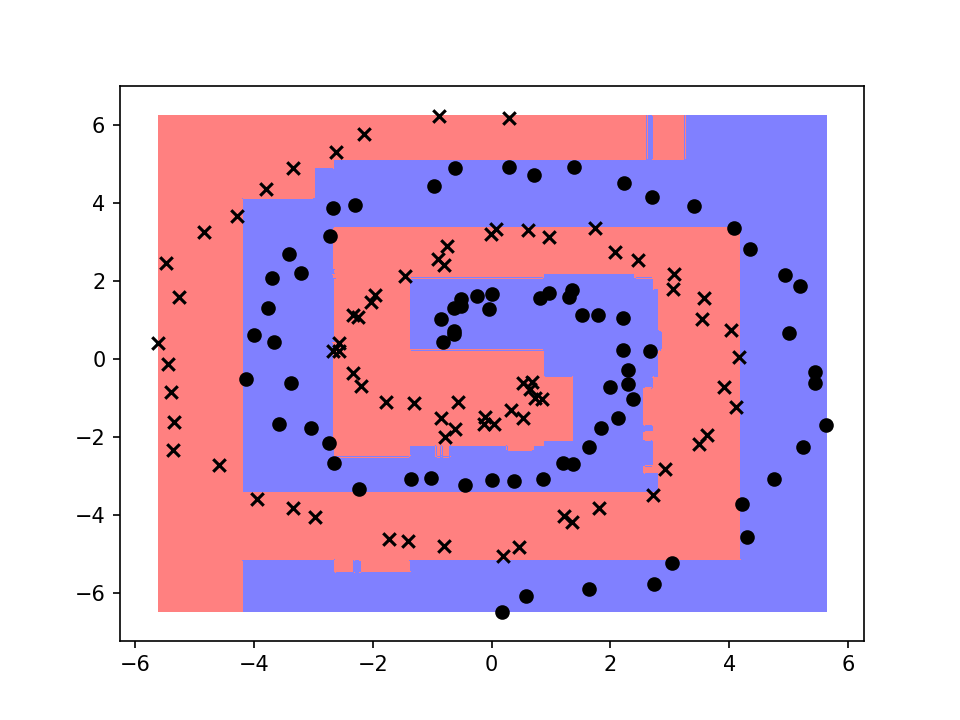

Training error: 0.0000
Testing error:  0.0667


In [26]:
trees,alphas=boosttree(xTrSpiral,yTrSpiral,maxdepth=3,maxiter=50)
visclassifier(lambda X:evalforest(trees,X,alphas),xTrSpiral,yTrSpiral)

print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

<IPython.core.display.Javascript object>


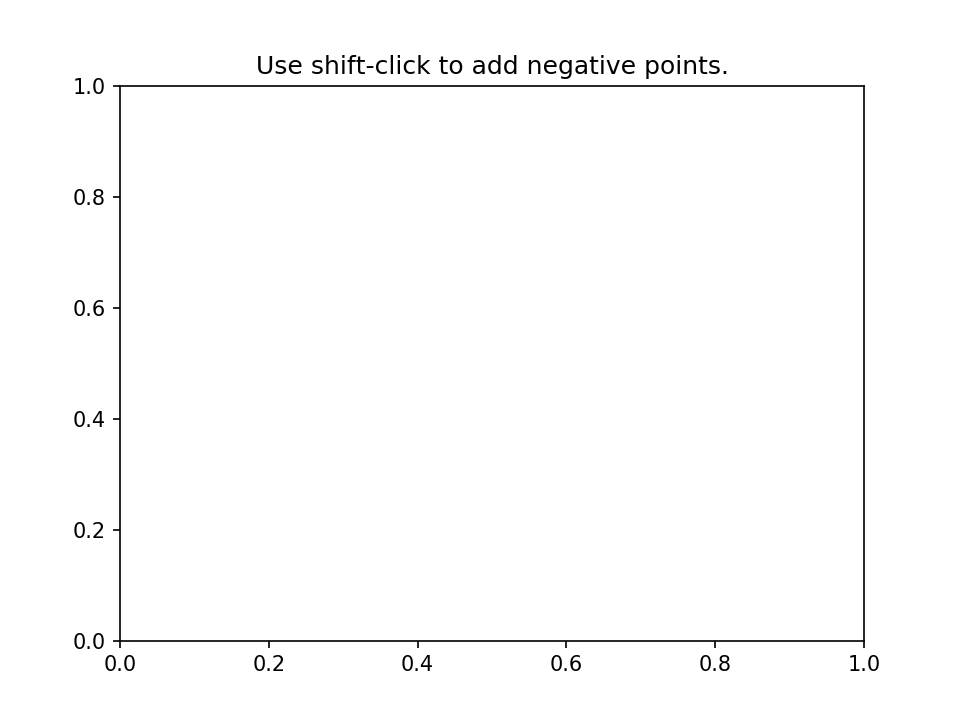

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [27]:
xTrain= np.array([[5,6],[2,5]])
yTrain = np.array([-1,1])
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)


def onclick_boost(event):
    """
    Visualize boosting, including new point
    """
    global xTrain,yTrain
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
            
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0,1,res)
    yrange = np.linspace(0,1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    # get forest
    forest,alphas=boosttree(xTrain,yTrain,maxdepth=3,maxiter=5)
    if len(forest) > 0:
        fun = lambda X: evalforest(forest,X,alphas)
        # test all of these points on the grid
        testpreds = fun(xTe)

        # reshape it back together to make our grid
        Z = testpreds.reshape(res, res)
        Z[0,0] = 1 # optional: scale the colors correctly

        plt.cla()    
        plt.xlim((0,1))
        plt.ylim((0,1))
        # fill in the contours for these predictions
        plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
cid = fig.canvas.mpl_connect('button_press_event', onclick_boost)
plt.title('Use shift-click to add negative points.')